# Counterfactual functionality of [polis.basis.ai](http://polis.basis.ai/)

In [43]:
import os
import logging
import matplotlib.pyplot as plt
import dill
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive


import plotly.express as px
import numpy as np
import plotly.graph_objects as go

from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features, list_interventions, list_outcomes, find_repo_root)
from cities.modeling.model_interactions import InteractionsModel
from cities.modeling.modeling_utils import (prep_data_for_interaction_inference, train_interactions_model)
root = find_repo_root()

In [53]:
features = list_available_features()
tensed_features = list_tensed_features()
interventions = list_interventions()
outcomes = list_outcomes()

covariates = [
        var
        for var in list_available_features()
        if var
        not in tensed_features 
    ]

print("covariates:", covariates)
print("interventions:", interventions)
print("outcomes", outcomes)

covariates: ['age_composition', 'burdens_energy', 'burdens_housing', 'diesel_matter_exposure', 'ethnic_composition', 'expected_agricultural_loss_rate', 'expected_building_loss_rate', 'expected_population_loss_rate', 'hazard', 'homeownership_rate', 'industry', 'median_owner_occupied_home_value', 'median_rent', 'proximity_to_hazardous_waste_sites', 'proximity_to_risk_management_plan_facilities', 'transport', 'urbanization']
interventions: ['spending_HHS', 'spending_commerce', 'spending_transportation']
outcomes ['gdp', 'industry_accommodation_food_services_total', 'industry_admin_support_services_total', 'industry_agriculture_total', 'industry_arts_recreation_total', 'industry_construction_total', 'industry_educational_services_total', 'industry_finance_insurance_total', 'industry_healthcare_social_services_total', 'industry_information_total', 'industry_management_enterprises_total', 'industry_manufacturing_total', 'industry_mining_total', 'industry_other_services_total', 'industry_prof

In [54]:
outcome='unemployment_rate'
intervention='spending_commerce'
forward_shift = 2

dg = DataGrabber()
dg.get_features_wide([outcome, intervention])

display(
dg.wide[intervention].head(),
dg.wide[outcome].head()
)

,GeoFIPS,GeoName,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,2364930.0,0.0,0.0,0.0,0.0
1,1003,"Baldwin, AL",0.0,1274298.0,0.0,186580.0,105434.0,105434.0,846583.0,0.0,1589502.0,50000.0,0.0,800000.0
2,1005,"Barbour, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1994425.0
3,1007,"Bibb, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1009,"Blount, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,GeoFIPS,GeoName,1990,1991,1992,1993,1994,1995,1996,1997,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,1001,"Autauga County, AL",6.5,6.8,6.5,5.9,5.0,5.6,3.9,3.9,...,6.3,5.8,5.2,5.1,4.0,3.6,2.9,5.3,2.8,2.3
1,1003,"Baldwin County, AL",5.3,5.5,6.3,5.9,4.8,4.7,4.4,3.5,...,6.7,6.1,5.6,5.4,4.2,3.6,2.9,6.1,2.9,2.4
2,1005,"Barbour County, AL",7.9,8.7,10.7,10.0,6.4,8.2,9.5,7.3,...,10.4,10.5,8.9,8.4,6.0,5.1,4.0,7.7,5.5,4.1
3,1007,"Bibb County, AL",9.2,11.8,11.1,11.5,7.7,6.5,7.1,7.4,...,8.0,7.2,6.7,6.5,4.5,4.0,3.3,7.3,3.4,2.5
4,1009,"Blount County, AL",6.4,5.8,6.2,5.2,4.2,4.4,3.3,3.0,...,6.4,6.1,5.4,5.4,4.1,3.5,2.8,4.5,2.4,2.2


In [72]:
int_data = dg.wide[intervention]['2016']
out_data = dg.wide[outcome]['2018']

regression_line = np.polyfit(int_data, out_data, 1)

print()
regression_fn = np.poly1d(regression_line)
line_values = regression_fn(int_data)


line_equation = f"naive impact of $1B: y = {round(regression_line[0] * 1e9, 2)}%"
fig = px.scatter(x=int_data, y=out_data, title='Unemployment vs. department of commerce funding',
                 )
fig.add_trace(go.Scatter(x=int_data, y=line_values, mode='lines'))
fig.update_layout(
                  title_x=0.5,  
                  title_y=0.92,  
                  annotations=[dict(text=line_equation, x=4 * 10e8, y=8, showarrow=False)],
                  template='presentation',showlegend=False)


fig.update_layout()
fig.show()


In [74]:
unfunded_mask = (int_data <= 0)
moderately_funded_mask = ((int_data > 10*1e7))

unfunded_data = out_data[unfunded_mask]
moderately_data = out_data[moderately_funded_mask]

df = pd.DataFrame({
    'Group': ['no funding'] * len(unfunded_data) + ['$10M < funding'] *
    len(moderately_data),
    'out_data': np.concatenate([unfunded_data, moderately_data])
})

fig = px.box(df, x='Group', y='out_data', points='all', 
             title='Comparing the unfunded with the moderately funded (2016->2018)')
mean_unfunded = unfunded_data.mean()
mean_moderately = moderately_data.mean()
fig.add_annotation(x= 0, y=mean_unfunded, text=f'Mean: {mean_unfunded:.2f}', showarrow=False)
fig.add_annotation(x= 1, y=mean_moderately, text=f'Mean: {mean_moderately:.2f}', showarrow=False)
fig.update_layout(template='presentation')
fig.show()


In [70]:

dg.get_features_std_long([intervention, outcome])
intervention_variable = dg.std_long[intervention].columns[-1]

loaded_data =  prep_data_for_interaction_inference(
        outcome_dataset=outcome,
intervention_dataset=intervention,
intervention_variable=intervention_variable,
forward_shift=forward_shift, 
    )

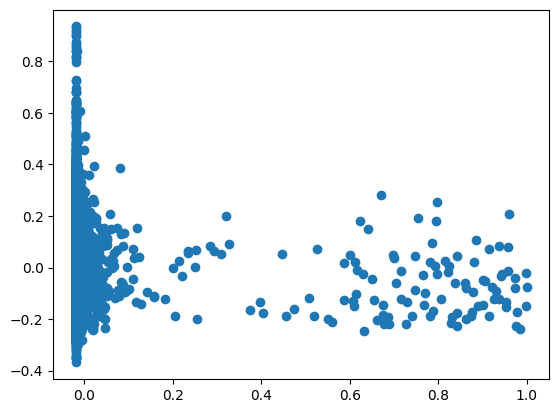

In [9]:
int_data = loaded_data['intervention']
out_data =  loaded_data['y']

unfunded_mask = (int_data <= 0)
moderately_funded_mask = ((int_data > 10*1e7))

unfunded_data = out_data[unfunded_mask]
moderately_data = out_data[moderately_funded_mask]

df = pd.DataFrame({
    'Group': ['no funding'] * len(unfunded_data) + ['$10M < funding'] *
    len(moderately_data),
    'out_data': np.concatenate([unfunded_data, moderately_data])
})

fig = px.box(df, x='Group', y='out_data', points='all', 
             title='Comparing the unfunded with the moderately funded (all years avaialable)')
mean_unfunded = unfunded_data.mean()
mean_moderately = moderately_data.mean()
fig.add_annotation(x= 0, y=mean_unfunded, text=f'Mean: {mean_unfunded:.2f}', showarrow=False)
fig.add_annotation(x= 1, y=mean_moderately, text=f'Mean: {mean_moderately:.2f}', showarrow=False)
fig.update_layout(template='presentation')
fig.show()
